In [ ]:
"""
Created on Mon Jan  8 2020

@author: Or Duek
Check Aging data timeseries
"""

# Aging timeseries analysis
# Using the connUtils.py file


In [1]:
import os
import pandas as pd
from nilearn import plotting
import numpy as np
from generalUtils import removeVars, timeSeriesSingle, createCorMat

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
# here we load the atlas - this is the Yeo one, but we can use others
#atlas_filename = '/home/or/Downloads/1000subjects_reference_Yeo/Yeo_JNeurophysiol11_SplitLabels/MNI152/Yeo2011_17Networks_N1000.split_components.FSL_MNI152_1mm.nii.gz'
#atlas_labes = pd.read_csv('/home/or/Downloads/1000subjects_reference_Yeo/Yeo_JNeurophysiol11_SplitLabels/Yeo2011_17networks_N1000.split_components.glossary.csv')
#coords = coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)
# take one subjects file 

In [7]:
# use aal atlas
import nilearn
aal_atlas = nilearn.datasets.fetch_atlas_aal(version='SPM12', data_dir=None, url=None, resume=True, verbose=1)


In [8]:
atlas_filename = aal_atlas.maps
atlas_labels = aal_atlas.labels

In [10]:
atlas_labels
atlas_labels.index('Occipital_Sup_L')

48

In [5]:
# put functional file, confound file and event file here - this is for one subject
func_file = '/media/Data/Aging/Preprocessed_Data/aging_output/fmriprep/sub-010/ses-1/func/sub-010_ses-1_task-taska_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz'
confound_file = '/media/Data/Aging/Preprocessed_Data/aging_output/fmriprep/sub-010/ses-1/func/sub-010_ses-1_task-taska_desc-confounds_regressors.tsv'
events_file = '/media/Data/work/AgingGLM/event_files/sub-010_taska.csv'

In [6]:
# create timeseries of all ROIs in atlas
timeSer= timeSeriesSingle(func_file, confound_file, atlas_filename)

[NiftiLabelsMasker.fit_transform] loading data from /home/or/nilearn_data/aal_SPM12/aal/atlas/AAL.nii
Resampling labels
[Memory]    0.1s, 0.0min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [11]:
timeSer.shape
# 116 regions in aal atlas

(487, 116)

In [12]:

def onsetDuration(onsets, durations, timeseries):
# this function receives array of onsets and duration of the same trial type and retures timeseries of this trialtype
    addDur = 8 # addint number of TRs to get the HRF
    beforeOnset = 3 # how many TRs before onset, to see full HRF
    newlist = []
    for onset, duration in zip(onsets, durations):
        
        newlist.append(timeseries[onset-beforeOnset:onset+duration+addDur, :]) 
    return newlist

In [13]:
def stratifyTimeseries (events_file, subject_timeseries, subject_id, trial_line):
    #trial_line is a parameter - if 0 then will create each line as file. If 1 then each task
    # grab subject events file
    events = pd.read_csv(events_file, sep=r'\s+')
    timeSeries = subject_timeseries#np.array(np.load(subject_timeseries, allow_pickle = True))
    
    # read line  by line and create matrix per line
    if trial_line==0:
        for line in events.iterrows():    
            numberRow = line[0] # take row number to add to matrix name later
            onset = round(line[1].onset) # take onset and round it
            duration = round(line[1].duration)
            trial_type = line[1].trial_type
            specTimeline = timeSeries[onset:(onset+duration),:]
    
    elif trial_line==1: # read by trial type and create specific timeline for each script
        PicLossOnset = []
        PicGainOnset = []
        MoneyLossOnset = []
        MoneyGainOnset = []
        PicLossDuration = []
        PicGainDuration = []
        MoneyLossDuration = []
        MoneyGainDuration = []
        for line in events.iterrows(): # runs trhough the events file, takes the specific files and create timeseries per each
            if line[1]['trial_type'].find('Mon_loss')!= -1:
              #  print('Mon_loss')
                MoneyLossOnset.append(round(line[1].onset))
                MoneyLossDuration.append(round(line[1].duration))
            elif line[1]['trial_type'].find('Mon_gain')!= -1:
               # print('Mon_gain')
                MoneyGainOnset.append(round(line[1].onset))
                MoneyGainDuration.append(round(line[1].duration))
            elif line[1]['trial_type'].find('Pic_loss')!= -1:
                #print('Pic_loss')
                PicLossOnset.append(round(line[1].onset))
                PicLossDuration.append(round(line[1].duration))
            elif line[1]['trial_type'].find('Pic_gain')!= -1:
               # print('Pic_gain')
                PicGainOnset.append(round(line[1].onset))
                PicGainDuration.append(round(line[1].duration))
        MoneyLoss_timeline = onsetDuration(MoneyLossOnset, MoneyLossDuration, timeSeries)
        MoneyGain_timeline = onsetDuration(MoneyGainOnset, MoneyGainDuration, timeSeries)
        PicLoss_timeline = onsetDuration(PicLossOnset, PicLossDuration, timeSeries)
        PicGain_timeline = onsetDuration(PicGainOnset, PicGainDuration, timeSeries)
    
        return MoneyGain_timeline, MoneyLoss_timeline, PicGain_timeline, PicLoss_timeline
   
    else:
        print ("Need to run by task")
    # extract subject specific timeseries from 3D array

In [14]:
moneyGaintime, MoneyLossTime, PicGainTime, PicLossTime = stratifyTimeseries(events_file, timeSer, '10', 1)

In [17]:
np.array(moneyGaintime).shape

(4, 17, 116)

In [18]:
def averaging_response(taskType_array):
    # this function receives taskType array and return averaged response
    average = np.mean(taskType_array, axis = 0)
    return np.array(average)

In [71]:
a = averaging_response(MoneyLossTime)
a_std = np.std(a, axis=1)
len(a)

17

<ErrorbarContainer object of 3 artists>

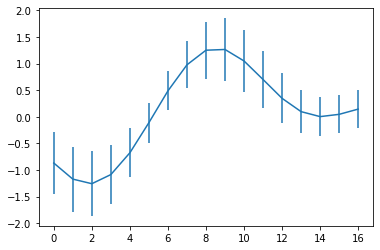

In [72]:
# here we plot the average of one task (adding N TRs to the real duration to get full HRF)
a = averaging_response(MoneyLossTime)
a_std = np.std(a, axis=1)
import matplotlib.pyplot as plt
#plt.plot(a[:,48])
plt.errorbar(range(0,len(a)),a[:,48], yerr=a_std)

In [38]:
np.std(averaging_response(MoneyLossTime))

0.5136908112377139

In [22]:
 pd.read_csv(events_file, sep=r'\s+')

,trial_type,onset,duration
0,Mon_loss,8,6
1,Mon_gain,26,6
2,Pic_loss,45,6
3,Pic_loss,111,6
4,Pic_gain,128,6
5,Pic_loss,169,6
6,Pic_gain,187,6
7,Mon_gain,227,6
8,Mon_loss,244,6
9,Pic_gain,263,6


In [23]:
# create full TRs with average response per trial
def overlay_average(timeSer, trial_type, events_file, task_array, region_num):
    a = np.zeros(timeSer.shape[0])
    trial = trial_type
    events = pd.read_csv(events_file, sep=r'\s+')
    onsets_of = np.array(events[events.trial_type== trial].onset)
    for i in onsets_of:
        print (i)
        a[i: i + np.array(task_array).shape[1]] = averaging_response(task_array)[:,region_num]
    return a

In [24]:
np.array(PicGainTime).shape


(4, 17, 116)

In [25]:
region_num = 48
moneygain_overlay = overlay_average(timeSer, 'Mon_gain', events_file, moneyGaintime, region_num)
moneyloss_overlay = overlay_average(timeSer, 'Mon_loss', events_file, MoneyLossTime, region_num)
picloss_overlay = overlay_average(timeSer, 'Pic_loss', events_file, PicLossTime, region_num)
picGain_overlay = overlay_average(timeSer, 'Pic_gain', events_file, PicGainTime, region_num)

26
227
369
467
8
244
346
449
45
111
169
323
128
187
263
386


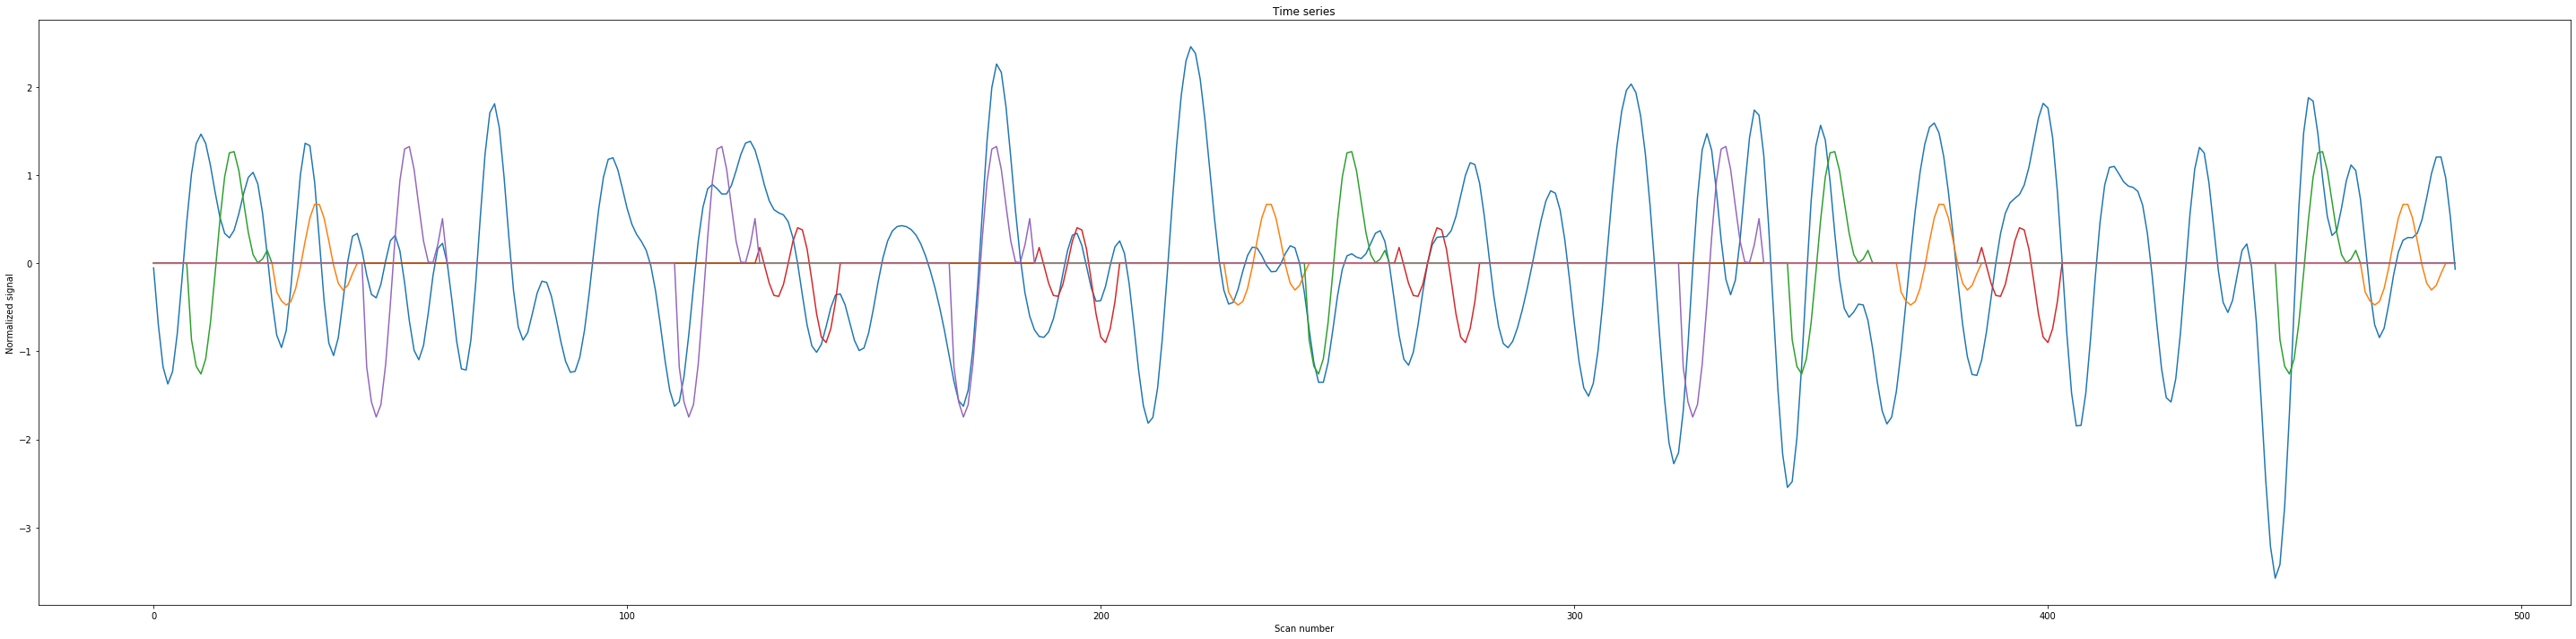

In [26]:
plt.figure(figsize = [40,10])
plt.plot(timeSer[:,43]) # time series of region 43 (V1)
plt.plot(moneygain_overlay[:])
plt.plot(moneyloss_overlay[:])
plt.plot(picGain_overlay[:])
plt.plot(picloss_overlay[:])
plt.title('Time series')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()